# <center> 🎓 Análisis Descriptivo </center>

***Descripción del DataSet***
| Variable                        | Definición                      |
|---------------------------------|---------------------------------|
| Activity Period                 | Periodo de actividad            |
| Operating Airline               | Aerolínea operativa             |
| Operating Airline IATA Code      | Código IATA de la aerolínea operativa |
| Published Airline               | Aerolínea publicada             |
| Published Airline IATA Code      | Código IATA de la aerolínea publicada |
| GEO Summary                     | Resumen GEO                     |
| GEO Region                      | Región GEO                      |
| Activity Type Code              | Código de tipo de actividad      |
| Price Category Code              | Código de categoría de precio    |
| Terminal                        | Terminal                        |
| Boarding Area                   | Área de embarque                |
| Passenger Count                 | Cantidad de pasajeros            |
| Adjusted Activity Type Code      | Código de tipo de actividad ajustado |
| Adjusted Passenger Count        | Cantidad de pasajeros ajustada    |
| Year                            | Año                             |
| Month                           | Mes                             |


In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import mean, round, std, max, min, max, col, sum, count, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.master("local").appName("Data-Exploration").getOrCreate()
spark

In [3]:
# Defino el Schema manualmente y cargo los datos
custom_schema = StructType([
    StructField("Activity Period", IntegerType(), True), # Para este análisis modifico la variable a numérica
    StructField("Operating Airline", StringType(), True),
    StructField("Operating Airline IATA Code", StringType(), True),
    StructField("Published Airline", StringType(), True),
    StructField("Published Airline IATA Code", StringType(), True),
    StructField("GEO Summary", StringType(), True),
    StructField("GEO Region", StringType(), True),
    StructField("Activity Type Code", StringType(), True),
    StructField("Price Category Code", StringType(), True),
    StructField("Terminal", StringType(), True),
    StructField("Boarding Area", StringType(), True),
    StructField("Passenger Count", IntegerType(), True),
    StructField("Adjusted Activity Type Code", StringType(), True),
    StructField("Adjusted Passenger Count", IntegerType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Month", StringType(), True),
    ])

data = spark.read.schema(custom_schema).option("delimiter", ",").option("header", "true").csv('work/data/Air_Traffic_Passenger_Statistics.csv')
data.printSchema()

root
 |-- Activity Period: integer (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



In [4]:
# Confirmo que el número de filas coincide con el fichero
print(f"Número de filas: {data.count()}")
data.show()

Número de filas: 15007
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                       

## 🎓 1.1 Exploración de Variables Numéricas

Nos solicitan calcular la media y desviación estandar de cada uno de los elementos del las columnas **Passenger Count** y **Adjusted Passenger Count**.

In [5]:
# Elimino los valores nulos
data_cleaned = data.dropna(subset=['Operating Airline IATA Code'])
print(f"Número de filas: {data.count()}")
print(f"Número de filas después de eliminar valores nulos: {data_cleaned.count()}")

Número de filas: 15007
Número de filas después de eliminar valores nulos: 14953


In [6]:
passenger_stats = data_cleaned.groupBy('Operating Airline').agg(round(mean('Passenger Count'), 2).alias('Mean Passenger Count'),
                           (round(std('Passenger Count'), 2).alias('Std Passenger Count')),
                           (round(mean('Adjusted Passenger Count'), 2).alias('Mean Adjusted Passenger Count')),
                           (round(std('Adjusted Passenger Count'), 2).alias('Std Adjusted Passenger Count')),
                           )
passenger_stats_ordered = passenger_stats.orderBy('Mean Passenger Count', ascending=False)
passenger_stats_ordered.show(73)
print(f"Número de Aerolíenas Únicas: 73")


+--------------------+--------------------+-------------------+-----------------------------+----------------------------+
|   Operating Airline|Mean Passenger Count|Std Passenger Count|Mean Adjusted Passenger Count|Std Adjusted Passenger Count|
+--------------------+--------------------+-------------------+-----------------------------+----------------------------+
|   American Airlines|           127164.39|           22044.24|                    127164.39|                    22044.24|
|  Southwest Airlines|            81188.16|           60358.22|                     81223.35|                    60310.95|
|      Virgin America|            74405.35|           68539.61|                     74405.35|                    68539.61|
|     United Airlines|            72732.06|          111407.61|                     72827.22|                   111353.45|
|     Delta Air Lines|             68498.5|           52441.71|                     68515.42|                    52420.02|
|          US Ai

In [7]:
# Calculo la media y desviación estandar para las columnas Passenger Count y Adjust Passenger Count
passenger_mean = data_cleaned.agg(round(mean('Passenger Count'), 2).alias('Mean Passenger Count'),
                           (round(std('Passenger Count'), 2).alias('Std Passenger Count')),
                           (round(mean('Adjusted Passenger Count'), 2).alias('Mean Adjusted Passenger Count')),
                           (round(std('Adjusted Passenger Count'), 2).alias('Std Adjusted Passenger Count')),
                           )
passenger_mean.show()

+--------------------+-------------------+-----------------------------+----------------------------+
|Mean Passenger Count|Std Passenger Count|Mean Adjusted Passenger Count|Std Adjusted Passenger Count|
+--------------------+-------------------+-----------------------------+----------------------------+
|            29345.62|           58398.45|                     29437.34|                    58362.88|
+--------------------+-------------------+-----------------------------+----------------------------+



### 📈 1.2 Distribución Variables Numéricas

/tmp/ipykernel_11290/554882805.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Adjusted Passenger count',data=columns_num, palette='viridis', ax=ax, legend=False)


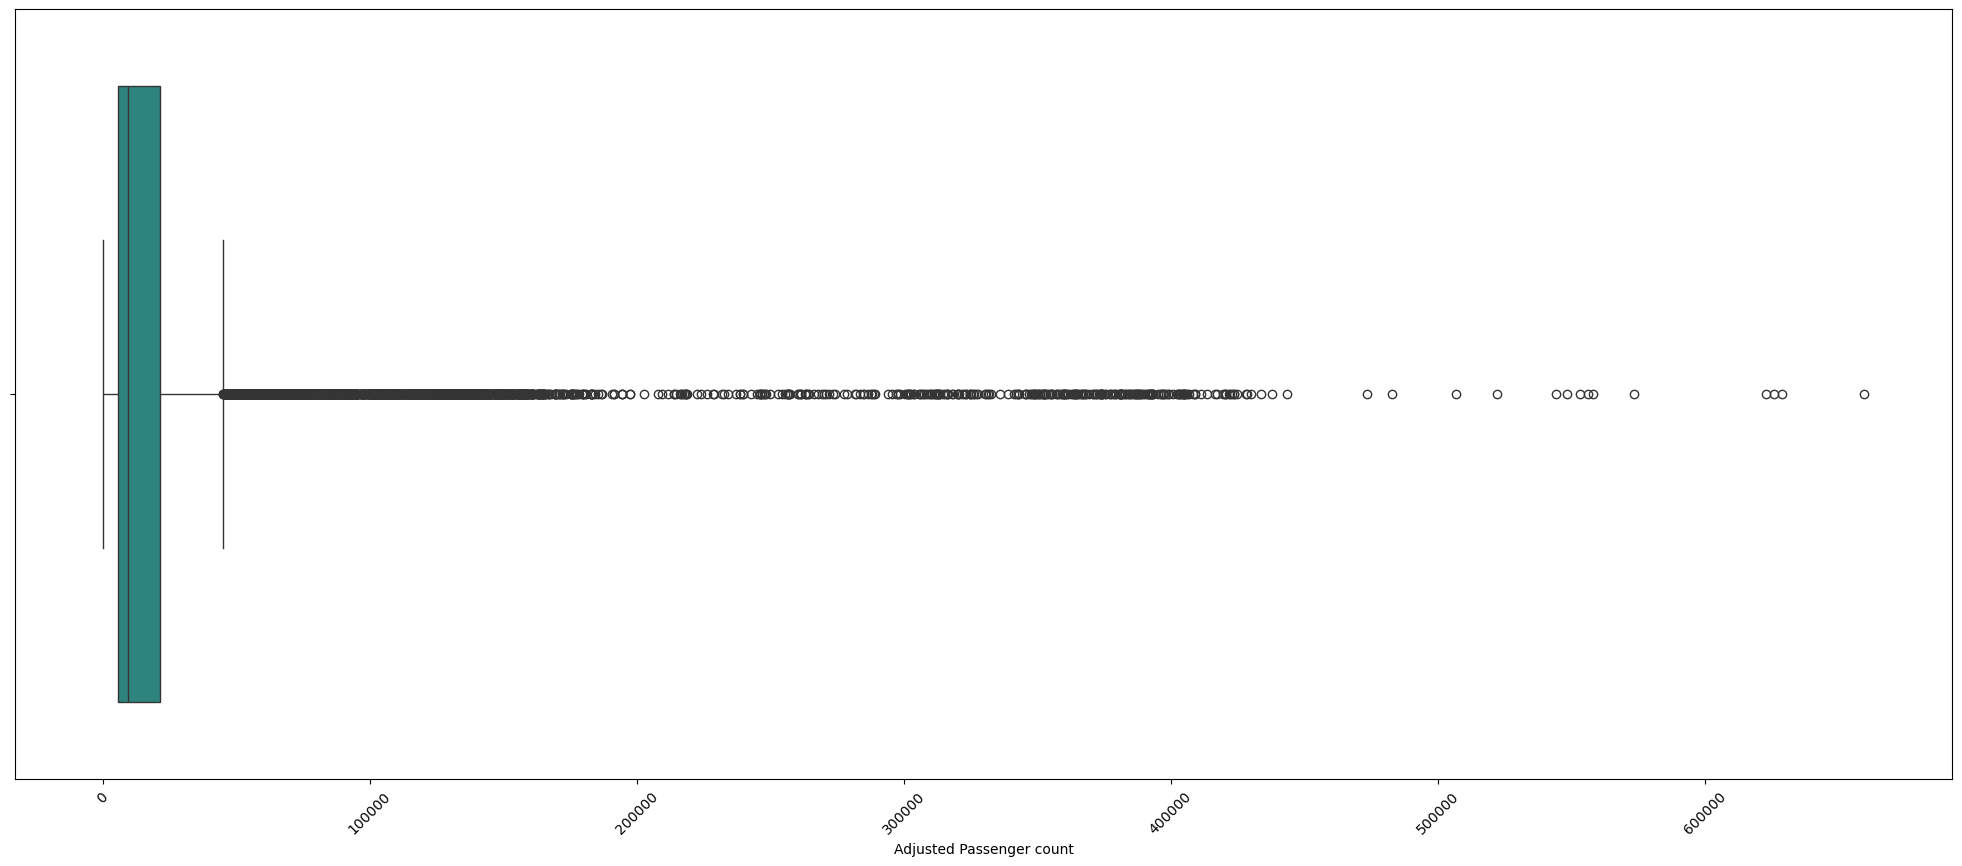

In [8]:
# Selecciono las columnas numéricas para transformarlas en un objeto de Pandas y generar un gráfico
columns_num = data_cleaned.select('Adjusted Passenger count')
columns_num = columns_num.toPandas()

# Diagrama de Caja
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
fig.subplots_adjust(hspace=0.3)
sns.boxplot(x='Adjusted Passenger count',data=columns_num, palette='viridis', ax=ax, legend=False)
ax.tick_params(axis='x', rotation=45)
plt.show()
# Al pasar el valor de hue='Passenger count', no genera el gráfico. no he sido capaz de encontrar el motivo

In [9]:
# Calculo la distribución de pasajeros por año
passenger_mean_year = data.groupBy('Year').agg(round(mean('Adjusted Passenger Count'),2).alias('Media por Año'))
passenger_mean_year_order = passenger_mean_year.orderBy('Year', ascending=True)
passenger_mean_year_order.show()

+----+-------------+
|Year|Media por Año|
+----+-------------+
|2005|     25002.34|
|2006|     24529.88|
|2007|     25401.59|
|2008|     26100.87|
|2009|     26887.03|
|2010|     28482.45|
|2011|     29529.09|
|2012|     32276.64|
|2013|     33145.63|
|2014|      34470.1|
|2015|     34292.53|
|2016|     30811.85|
+----+-------------+



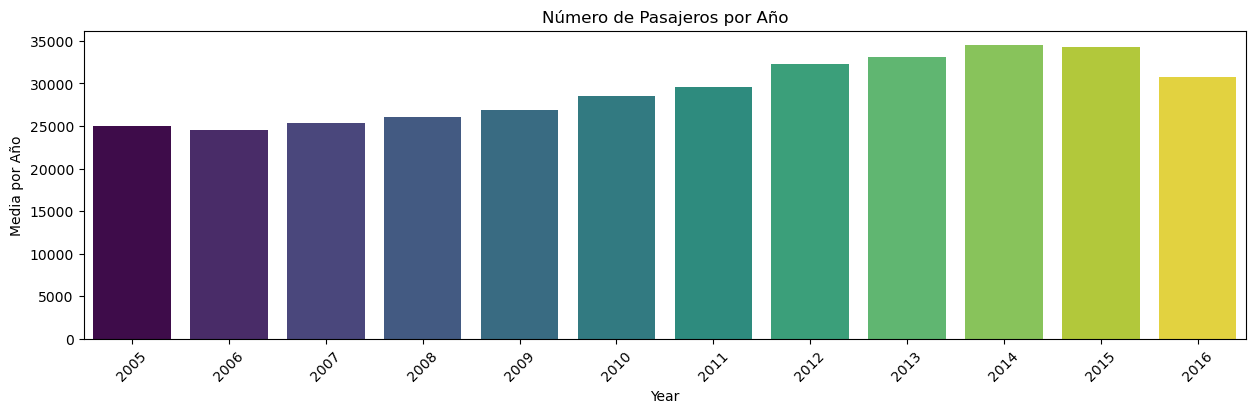

In [10]:
data_year = passenger_mean_year_order.toPandas()
# Generar gráfico de barras
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.barplot(x='Year', y='Media por Año', hue='Year', data=data_year, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('Year')
ax.set_ylabel('Media por Año')
ax.set_title('Número de Pasajeros por Año')
ax.tick_params(axis='x', rotation=45)
plt.show()

## 🎓 2.1 Exploración de Variables Categóricas

Vamos a llevar a cabo un conjunto de análisis que incluye cálculos, agrupaciones y conteos con el propósito de explorar en detalle el conjunto de datos y comprender la distribución de sus valores. Nuestra meta principal es identificar las aerolíneas con mayor número de pasajeros, determinar las regiones más transitadas y obtener información sobre las aerolíneas que operan en dichas regiones. Este enfoque nos permitirá obtener perspectivas clave sobre la composición del conjunto de datos.

### 🧮 Funciones

In [11]:
########################
# Listado de Funciones #
########################

def categorical_stats (column:str) -> None:
     '''
     Devuelve los valores únicos de una variable categórica
     Parameters:
     - column -> str, nombre de la columna sobre la realizar el 
     '''
     result = data_cleaned.select(column).distinct()
     result.show()

# Creo una función para ver el número de ocurrencias de las variables categóricas y su porcentaje, devolviendo un objeto de Pandas
def categorical_count (column:str) -> pd.DataFrame:
    '''
    Calcula el número de ocurrencias de cada valor único y muestra el porcentaje de cada valor en relación
    al total de ocurrencias
    Parameters: 
    - column -> str, nombre de la columna sobre la cual realiza el conteo
    Return:
    - Devuelve un objeto de Pandas
    '''
    result = data_cleaned.groupBy(column).agg(count("*").alias('numero_ocurrencias'))
    total_count = result.agg(sum('numero_ocurrencias')).collect()[0][0]
    result = result.withColumn('porcentaje', round(col('numero_ocurrencias') / total_count * 100, 2))
    result_ordered = result.orderBy(col('numero_ocurrencias').desc())
    result_pandas = result_ordered.toPandas()
    return result_pandas

def year_airline (year:int) -> None:
    '''
    Muestra un gráfico de barras que representa el número de pasajeros ajustados por aerolínea para un año específico.
    Parameters: 
    - year -> int, año para el cual se quiere visualizar la información.
    '''
    grouped_data = data_cleaned.groupBy('Year', 'Operating Airline').agg(sum('Adjusted Passenger Count').alias('Total Adjusted Passenger Count'))
    result = grouped_data.filter(grouped_data['Year'] == year)
    result = result.orderBy('Total Adjusted Passenger Count', ascending=False)

    result_pandas = result.toPandas()
    # Generar gráfico de barras
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Total Adjusted Passenger Count', y='Operating Airline',hue='Total Adjusted Passenger Count', data=result_pandas, palette='viridis', legend=False)

    # Configurar etiquetas y título
    plt.xlabel('Total Adjusted Passenger Count')
    plt.ylabel('Operating Airline')
    plt.title('Número de Pasajeros por Aerolínea')
    plt.gca().set_xticks([])
    
    plt.show()

### 📈 2.2 Distribución de la variable GEO Region

In [12]:
categorical_count('GEO Region')

,GEO Region,numero_ocurrencias,porcentaje
0,US,5757,38.50
1,Asia,3272,21.88
2,Europe,2078,13.90
3,Canada,1418,9.48
4,Mexico,1115,7.46
5,Australia / Oceania,737,4.93
6,Central America,272,1.82
7,Middle East,214,1.43
8,South America,90,0.60


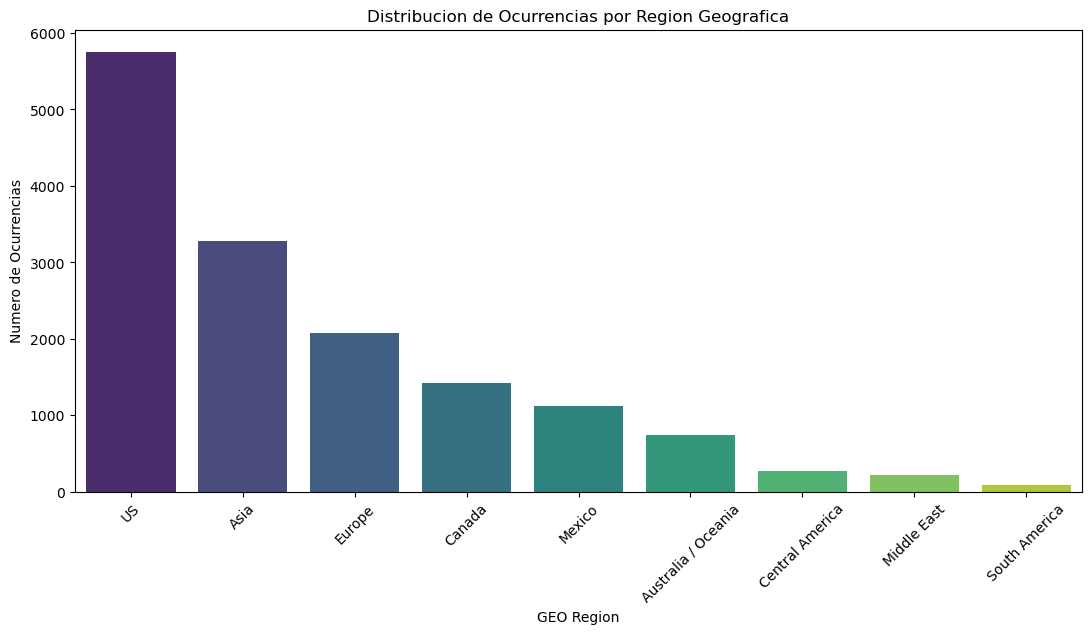

In [13]:
plot_region = categorical_count('GEO Region')
# Generar gráfico de barras
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
sns.barplot(x='GEO Region', y='numero_ocurrencias', hue='GEO Region', data=plot_region, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('GEO Region')
ax.set_ylabel('Numero de Ocurrencias')
ax.set_title('Distribucion de Ocurrencias por Region Geografica')
ax.tick_params(axis='x', rotation=45)
plt.show()

In [14]:
# Calculo la média de pasajeros por region
region_men = data.groupBy('GEO Region').agg(
    round(mean('Passenger Count'), 2).alias('Media por Región')
)
region_men_order = region_men.orderBy('Media por Región', ascending=False)
region_men_order.show()

+-------------------+----------------+
|         GEO Region|Media por Región|
+-------------------+----------------+
|                 US|        58330.34|
|               Asia|         13435.0|
|             Europe|        12755.65|
|             Canada|         9777.97|
|        Middle East|         8658.61|
|             Mexico|         7173.62|
|Australia / Oceania|         6417.02|
|    Central America|         4946.72|
|      South America|         2786.01|
+-------------------+----------------+



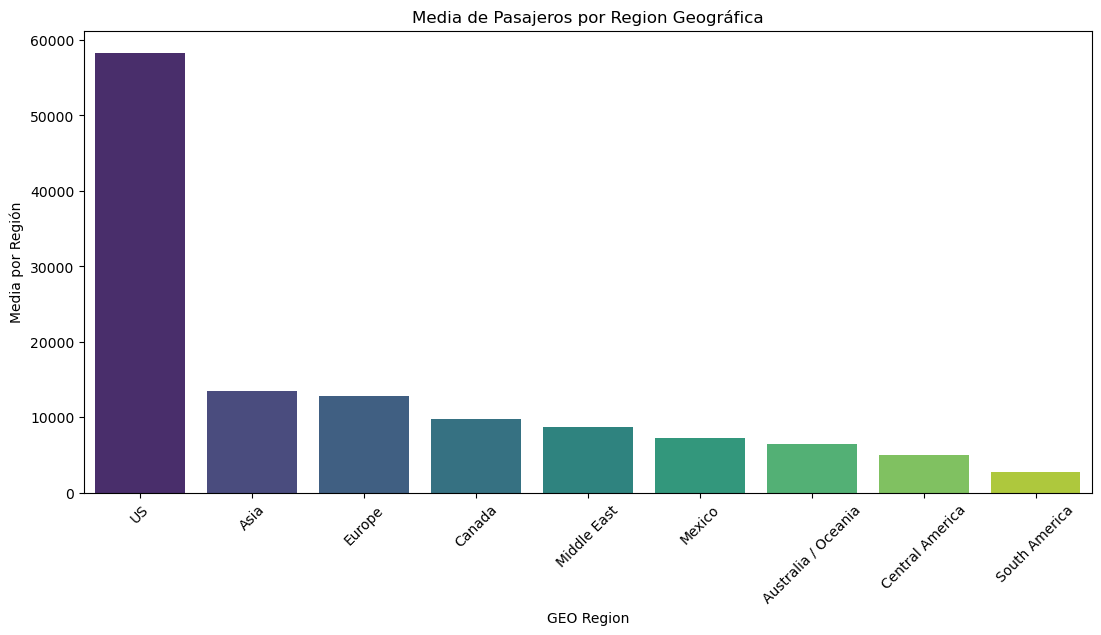

In [15]:
panda_region = region_men_order.toPandas()
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
sns.barplot(x='GEO Region', y='Media por Región', hue='GEO Region', data=panda_region, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('GEO Region')
ax.set_ylabel('Media por Región')
ax.set_title('Media de Pasajeros por Region Geográfica')
ax.tick_params(axis='x', rotation=45)
plt.show()

### 📈 2.3 Distribución variable Year

In [16]:
categorical_count('Year')

,Year,numero_ocurrencias,porcentaje
0,2015,1460,9.76
1,2008,1433,9.58
2,2007,1409,9.42
3,2009,1393,9.32
4,2010,1377,9.21
5,2011,1375,9.20
6,2006,1369,9.16
7,2014,1364,9.12
8,2012,1362,9.11
9,2013,1346,9.00


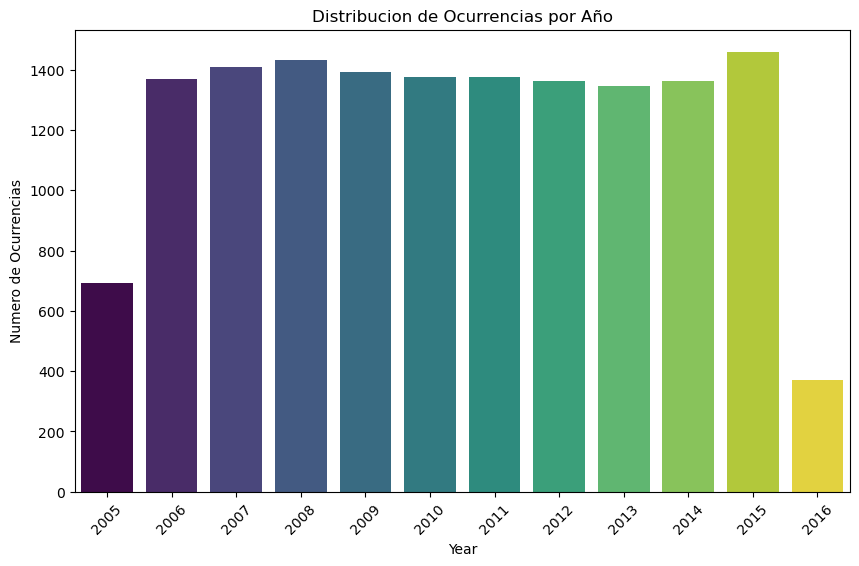

In [17]:
plot_year = categorical_count('Year')
# Generar gráfico de barras
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x='Year', y='numero_ocurrencias', hue='Year', data=plot_year, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('Year')
ax.set_ylabel('Numero de Ocurrencias')
ax.set_title('Distribucion de Ocurrencias por Año')
ax.tick_params(axis='x', rotation=45)
plt.show()

### 📈 2.3 Distribución Variable Price Category

In [18]:
categorical_count('Price Category Code')

,Price Category Code,numero_ocurrencias,porcentaje
0,Other,13069,87.4
1,Low Fare,1884,12.6


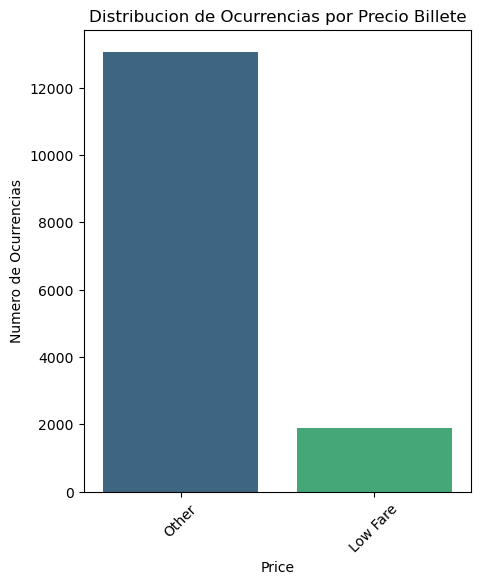

In [19]:
plot_price = categorical_count('Price Category Code')
# Generar gráfico de barras
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
sns.barplot(x='Price Category Code', y='numero_ocurrencias', hue='Price Category Code', data=plot_price, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('Price')
ax.set_ylabel('Numero de Ocurrencias')
ax.set_title('Distribucion de Ocurrencias por Precio Billete')
ax.tick_params(axis='x', rotation=45)
plt.show()

### 📈 2.4 Distribución Variable GEO Summary

In [20]:
categorical_count('GEO Summary')

,GEO Summary,numero_ocurrencias,porcentaje
0,International,9196,61.5
1,Domestic,5757,38.5


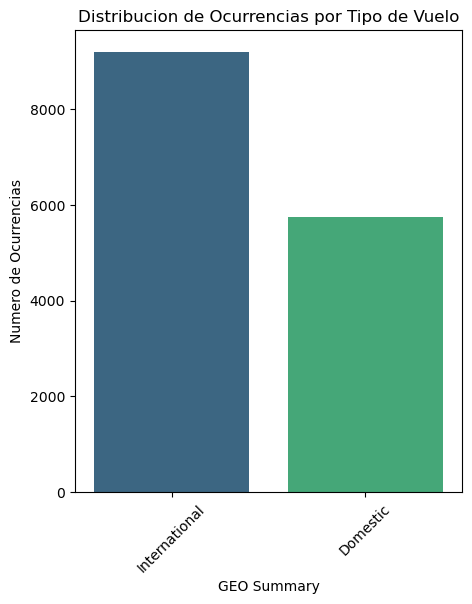

In [21]:
plot_geo = categorical_count('GEO Summary')
# Generar gráfico de barras
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
sns.barplot(x='GEO Summary', y='numero_ocurrencias', hue='GEO Summary', data=plot_geo, palette='viridis', ax=ax, legend=False)
ax.set_xlabel('GEO Summary')
ax.set_ylabel('Numero de Ocurrencias')
ax.set_title('Distribucion de Ocurrencias por Tipo de Vuelo')
ax.tick_params(axis='x', rotation=45)
plt.show()

### 📈 2.5 Distribución de Pasajeros por Aerolinea por Año

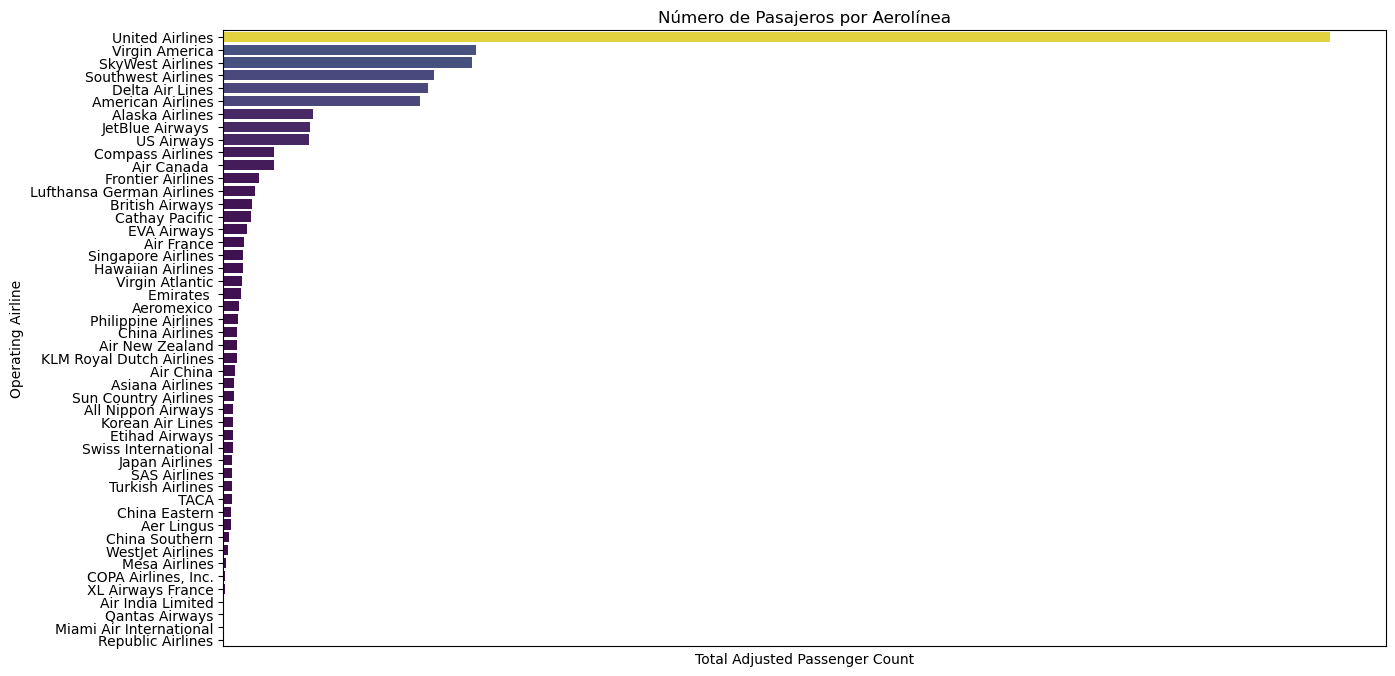

In [22]:
year_airline(2015)

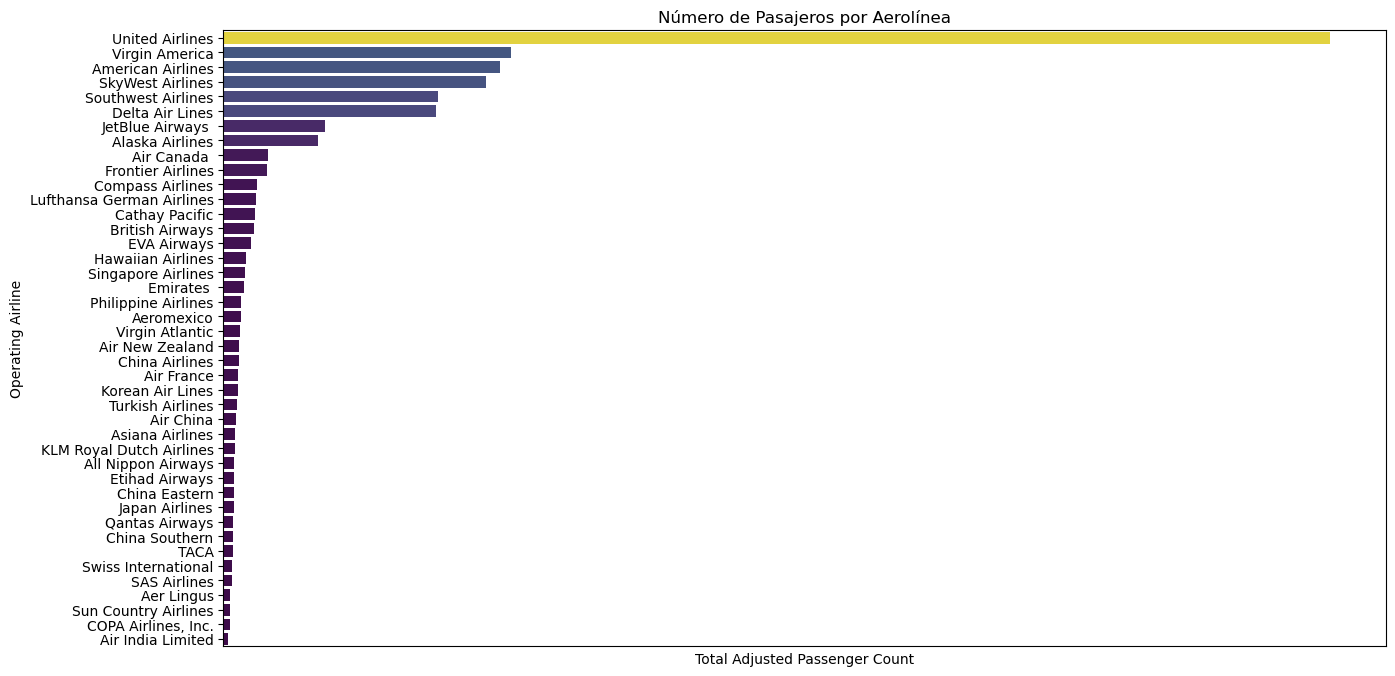

In [23]:
year_airline(2016)

### 2.5 📈 Distribución Variable Operating Airline por GEO Region

In [24]:
airline_region = data_cleaned.groupBy('GEO Region', 'Operating Airline').count()
airline_region.show(100)

+-------------------+--------------------+-----+
|         GEO Region|   Operating Airline|count|
+-------------------+--------------------+-----+
|             Canada|United Airlines -...|  266|
|             Europe| Swiss International|  139|
|             Mexico|     Alaska Airlines|  300|
|               Asia| Philippine Airlines|  258|
|             Europe|    Turkish Airlines|   24|
|             Europe|KLM Royal Dutch A...|  258|
|                 US|     Mesaba Airlines|   44|
|                 US|     Delta Air Lines|  286|
|             Mexico|Sun Country Airlines|   11|
|                 US|   Hawaiian Airlines|  258|
|               Asia|Evergreen Interna...|    2|
|             Canada|Miami Air Interna...|    1|
|             Europe|United Airlines -...|  278|
|             Canada|     Air Canada Jazz|   14|
|        Middle East|           Emirates |  180|
|             Canada|     Alaska Airlines|  109|
|                 US|        ATA Airlines|   41|
|               Asia

In [25]:
# Filtra las filas donde 'GEO Region' es igual a "US"
filter_us = data_cleaned.filter(col('GEO Region') == "US")

# Agrupa por 'Operating Airline' y cuenta las filas en cada grupo
data_us = (filter_us.groupBy('Operating Airline').count().orderBy('count', ascending=False))

# Muestra los resultados
data_us.show(33)

+--------------------+-----+
|   Operating Airline|count|
+--------------------+-----+
|United Airlines -...|  789|
|    SkyWest Airlines|  569|
|     United Airlines|  444|
|     Alaska Airlines|  342|
|  Southwest Airlines|  309|
|          US Airways|  304|
|     Delta Air Lines|  286|
|   American Airlines|  272|
|   Frontier Airlines|  260|
|   Hawaiian Airlines|  258|
|Sun Country Airlines|  239|
|     AirTran Airways|  226|
|    JetBlue Airways |  222|
|        Horizon Air |  216|
|      Virgin America|  211|
|  Northwest Airlines|  128|
|       Mesa Airlines|  117|
|    Midwest Airlines|  116|
|American Eagle Ai...|  106|
|    Compass Airlines|   88|
|     Mesaba Airlines|   44|
|        ATA Airlines|   41|
| ExpressJet Airlines|   32|
|   Republic Airlines|   24|
|     Spirit Airlines|   24|
|         Ameriflight|   22|
|Atlantic Southeas...|   22|
|       Allegiant Air|   16|
|Miami Air Interna...|   15|
|    Independence Air|   10|
|      Atlas Air, Inc|    2|
|        Xtra 

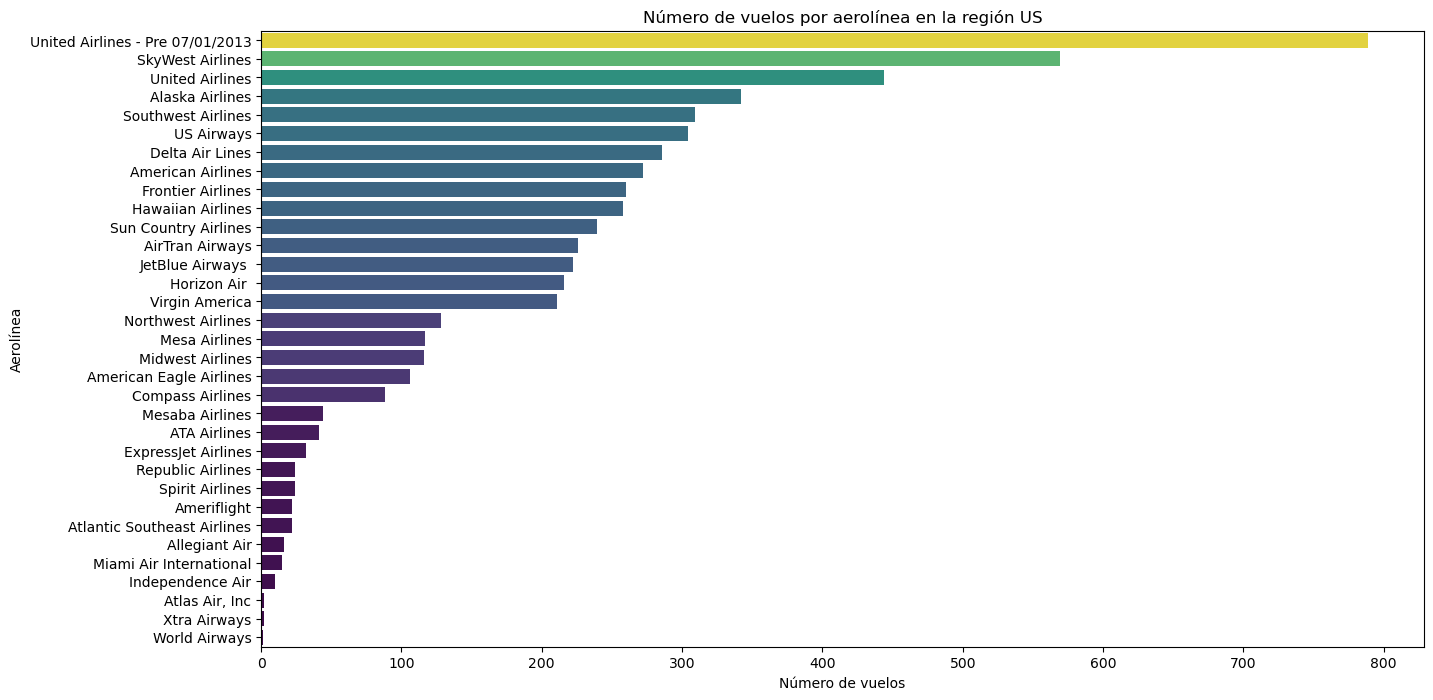

In [26]:
# Transformo el DataFrame a un DataFrame de Pandas
df_pd = data_us.toPandas()

# Crear un gráfico de barras horizontales con Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='count', y='Operating Airline', data=df_pd, palette='viridis', legend=False, hue='count')
plt.xlabel('Número de vuelos')
plt.ylabel('Aerolínea')
plt.title('Número de vuelos por aerolínea en la región US')
plt.show()

In [27]:
# Filtra las filas donde 'GEO Region' es igual a "US"
filter_europe = data_cleaned.filter(col('GEO Region') == "Europe")

# Agrupa por 'Operating Airline' y cuenta las filas en cada grupo
data_europe = (filter_europe.groupBy('Operating Airline').count().orderBy('count',ascending = False))

# Muestra los resultados
data_europe.show(100)

+--------------------+-----+
|   Operating Airline|count|
+--------------------+-----+
|United Airlines -...|  278|
|          Air France|  258|
|     British Airways|  258|
|     Virgin Atlantic|  258|
|KLM Royal Dutch A...|  258|
|Lufthansa German ...|  258|
| Swiss International|  139|
|          Aer Lingus|   98|
|        SAS Airlines|   72|
|     United Airlines|   66|
|          Air Berlin|   36|
|   XL Airways France|   31|
|    Turkish Airlines|   24|
|     BelAir Airlines|   22|
|          Icelandair|   20|
|       World Airways|    2|
+--------------------+-----+



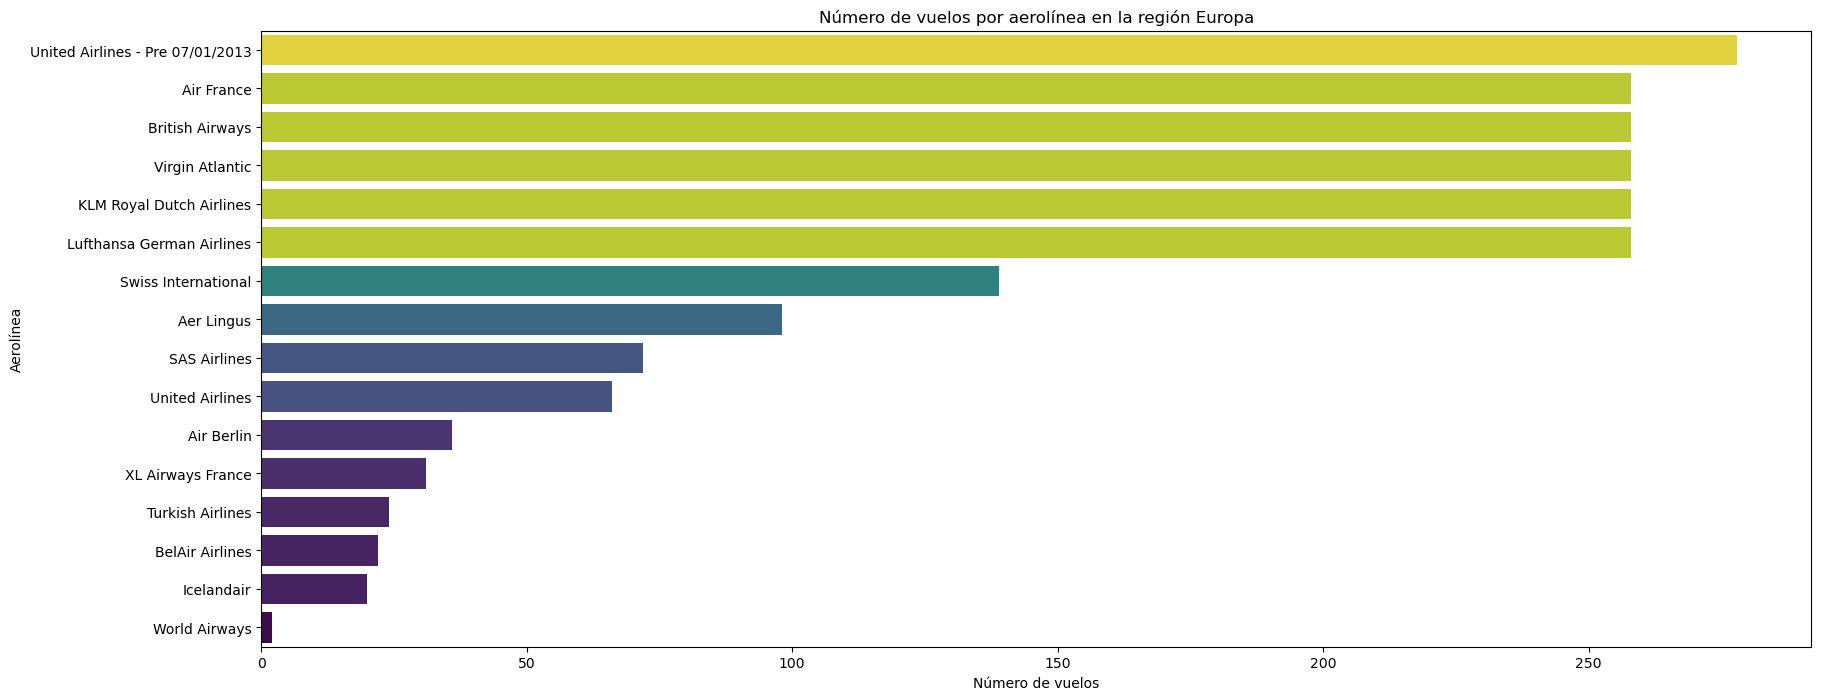

In [28]:
#Transformo el DataFrame a un DataFrame de Pandas
data_pd = data_europe.toPandas()

# Crear un gráfico de barras horizontales con Seaborn
plt.figure(figsize=(20, 8))
sns.barplot(x='count', y='Operating Airline', data=data_pd, palette='viridis', legend=False, hue='count')
plt.xlabel('Número de vuelos')
plt.ylabel('Aerolínea')
plt.title('Número de vuelos por aerolínea en la región Europa')
plt.show()

In [29]:
# Filtra las filas donde 'GEO Region' es igual a "US"
filter_asia = data_cleaned.filter(col('GEO Region') == "Asia")

# Agrupa por 'Operating Airline' y cuenta las filas en cada grupo
data_asia = (filter_asia.groupBy('Operating Airline').count().orderBy('count',ascending = False))

# Muestra los resultados
data_asia.show(100)

+--------------------+-----+
|   Operating Airline|count|
+--------------------+-----+
|United Airlines -...|  279|
|      Japan Airlines|  259|
|           Air China|  259|
|      Cathay Pacific|  258|
| Philippine Airlines|  258|
|     Asiana Airlines|  258|
|      China Airlines|  258|
|    Korean Air Lines|  258|
|  All Nippon Airways|  258|
|  Singapore Airlines|  258|
|         EVA Airways|  258|
|  Northwest Airlines|  112|
|     Delta Air Lines|  100|
|       China Eastern|   72|
|     United Airlines|   69|
|      China Southern|   32|
|         Jet Airways|   16|
|   Air India Limited|    8|
|Evergreen Interna...|    2|
+--------------------+-----+



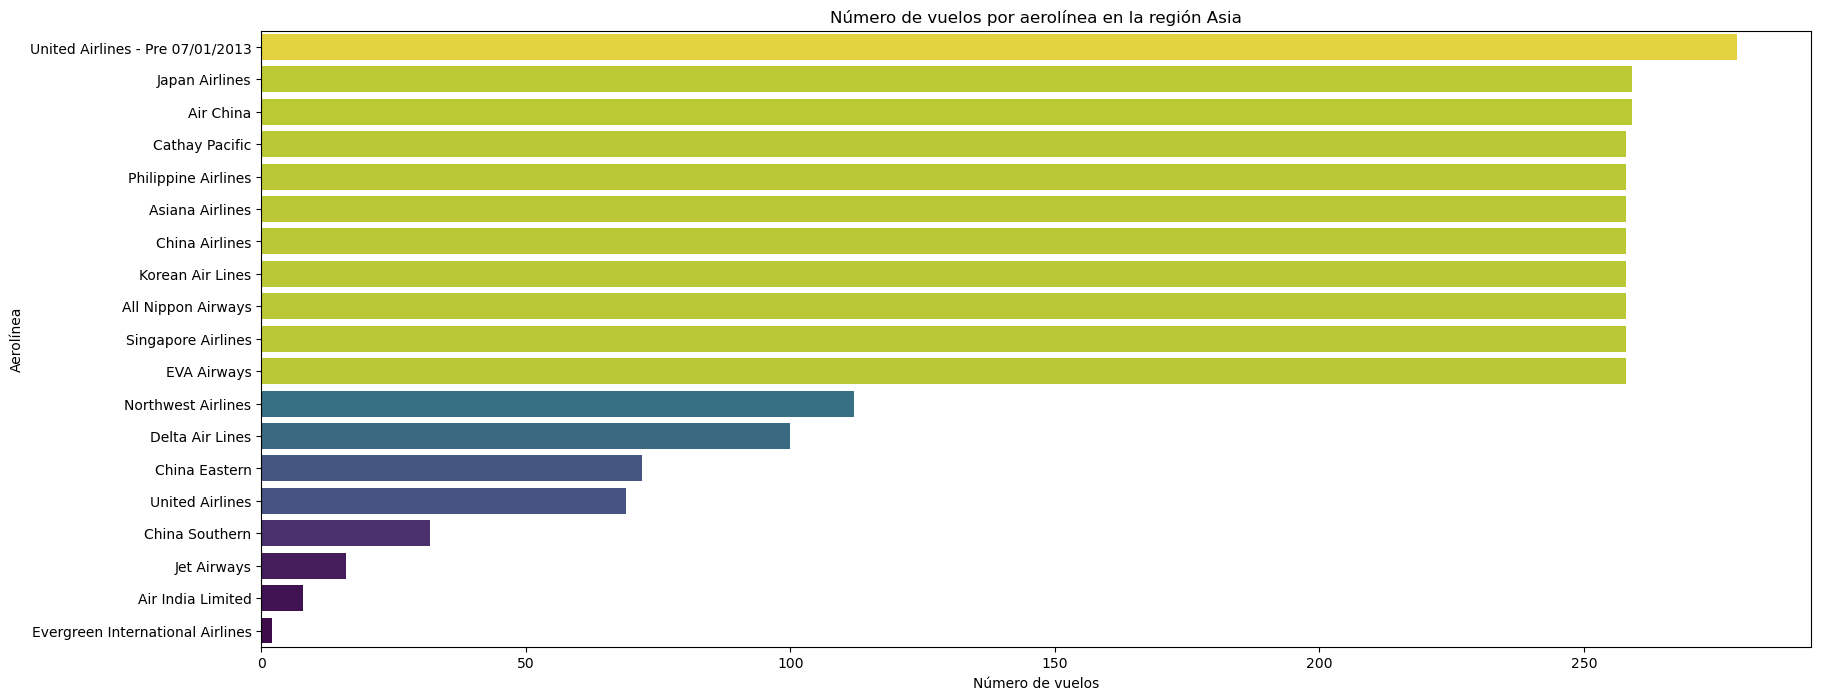

In [30]:
#Transformo el DataFrame a un DataFrame de Pandas
datas_pd = data_asia.toPandas()

# Crear un gráfico de barras horizontales con Seaborn
plt.figure(figsize=(20, 8))
sns.barplot(x='count', y='Operating Airline', data=datas_pd, palette='viridis', legend=False, hue='count')
plt.xlabel('Número de vuelos')
plt.ylabel('Aerolínea')
plt.title('Número de vuelos por aerolínea en la región Asia')
plt.show()

## 🧑‍💻 3.1 Análisis Descriptivo

Tras analizar las métricas estadísticas de las columnas `Passenger Count` y `Adjusted Passenger Count`, **se destaca una ligera discrepancia entre ambos conjuntos de valores**, donde los valores de "Adjusted Passenger Count" son ligeramente superiores. Es plausible que la columna "Passenger Count" represente el número de pasajeros que adquirieron el billete, mientras que "Adjusted Passenger Count" podría referirse al número de pasajeros que efectivamente tomaron el vuelo.

La media general de pasajeros se sitúa en `29,437.34`. Al examinar los datos por año, `se observa un incremento constante en la media de pasajeros desde el 2005, sin interrupciones hasta el año 2014`. Sin embargo, en 2015 se registra una ligera disminución en el volumen de pasajeros, pasando de una media de 34,470.10 en 2014 a 34,292.53 en 2015. El mayor descenso se identifica en 2016, donde la media se sitúa en 30,811.85, marcando así un punto notable de contracción en la tendencia ascendente observada en los años previos.

Se evidencia una distribución bastante uniforme a lo largo de todos los años, con excepción de 2005 y 2016. Es probable que esta disparidad se deba a que la recopilación de datos para estos periodos no sea completa. El año 2005 representa el primer año de recopilación de datos, y 2016 no abarca el año completo. ***Sería pertinente evaluar la conveniencia de excluir los datos correspondientes a 2005 y 2016 con el fin de analizar periodos anuales completos.***


Las observaciones realizadas revelan la `presencia de un total de 73 aerolíneas` en nuestro conjunto de datos. Entre ellas, `American Airlines` destaca con una impresionante media de pasajeros de 127,164.39, seguida por `Southwest Airlines` con 81,223.35, `Virgin America` con 74,405.35 y `United Airlines` con 72,827.22. Estas aerolíneas lideran en volumen de pasajeros, todas superando la media de 70,000 pasajeros.

En el extremo opuesto de la escala, encontramos a `Evergreen International Airlines` 2, `Ameriflight` 5.36, `Atlas Air, Inc` 35.5, y `Xtra Airways` 73. Ninguna de estas aerolíneas logra alcanzar la media de 100 pasajeros, situándose en una categoría de menor volumen en comparación con sus contrapartes líderes.

Los datos revelan que las compañías aéreas que operan en `Estados Unidos registran la mayor cantidad de vuelos`, alcanzando un total de 5,757, lo que representa el 38.50% de todo el conjunto de datos. `Asia y Europa ocupan el segundo y tercer lugar respectivamente`, con 3,272 y 2,078 vuelos cada uno, constituyendo el 21.88% y el 13.90%.

En contraste, `América del Sur, Oriente Medio y América Central presentan una menor frecuencia`, con 90, 214 y 272 vuelos respectivamente. Estas cuatro zonas geográficas combinadas **no alcanzan ni siquiera el 4% del total de los datos** recopilados en el conjunto de datos.

El 61.6% de los vuelos adjuntos al dataset perteneces a buenos Internacionales frente al 38.5% considerados como vuelos domesticos.

Como era de anticipar, **la correlación entre el número de vuelos y el volumen de pasajeros es positiva**. En consecuencia, la zona de Estados Unidos exhibe una media de pasajeros de 58,330.34, seguida por Asia con 13,435 y Europa con 12,755.65. Este patrón sugiere una relación directa entre la cantidad de vuelos y el volumen de pasajeros, donde regiones con más vuelos tienden a tener mayores medias de pasajeros.

Un dato que me ha sorprendido es la distribución en función del costo del billete. **Se destaca que el `87.4%` de los vuelos realizados han sido abonados con una tarifa denominada como `other`**, la cual entendemos que hace referencia a tarifas sin descuento o a la tarificación de billetes en clases preferentes. Los billetes más asequibles, comúnmente conocidos como `low cost`, representan el 12.6%, **evidenciando así una marcada predominancia de la categoría "other" en la estructura de tarifas**.

## 🧑‍💻 4.1 Análisis Correlativo

In [31]:
# Lista de columnas categóricas
categorical_columns = ['Operating Airline', 'Operating Airline IATA Code', 'Published Airline', 
                        'Published Airline IATA Code', 'GEO Summary', 'GEO Region', 
                        'Activity Type Code', 'Price Category Code', 'Terminal', 'Boarding Area']

# uso el método StringIndexer para transformar cada columa categórica. Esto añade un índice numérico a cada columna
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data_cleaned) for col in categorical_columns]

# genero un pipeline para ejecutar todos los StringIndexer
pipeline = Pipeline(stages=indexers)

# Aplico el pipeline al conjunto de datos
df_indexed = pipeline.fit(data_cleaned).transform(data_cleaned)

In [32]:
# Selecciono las columnas indexadas que voy a usar en el análisis de correlación
indexed_columns = [col+"_index" for col in categorical_columns]

# Genero un vector assembler para combinar las columnas indexadas en un solo vector
assembler = VectorAssembler(inputCols=indexed_columns, outputCol="features")
assembled_df = assembler.transform(df_indexed)

# Calculamos la matriz de correlación
correlation_matrix = Correlation.corr(assembled_df, "features").head()
correlation_array = correlation_matrix[0].toArray()

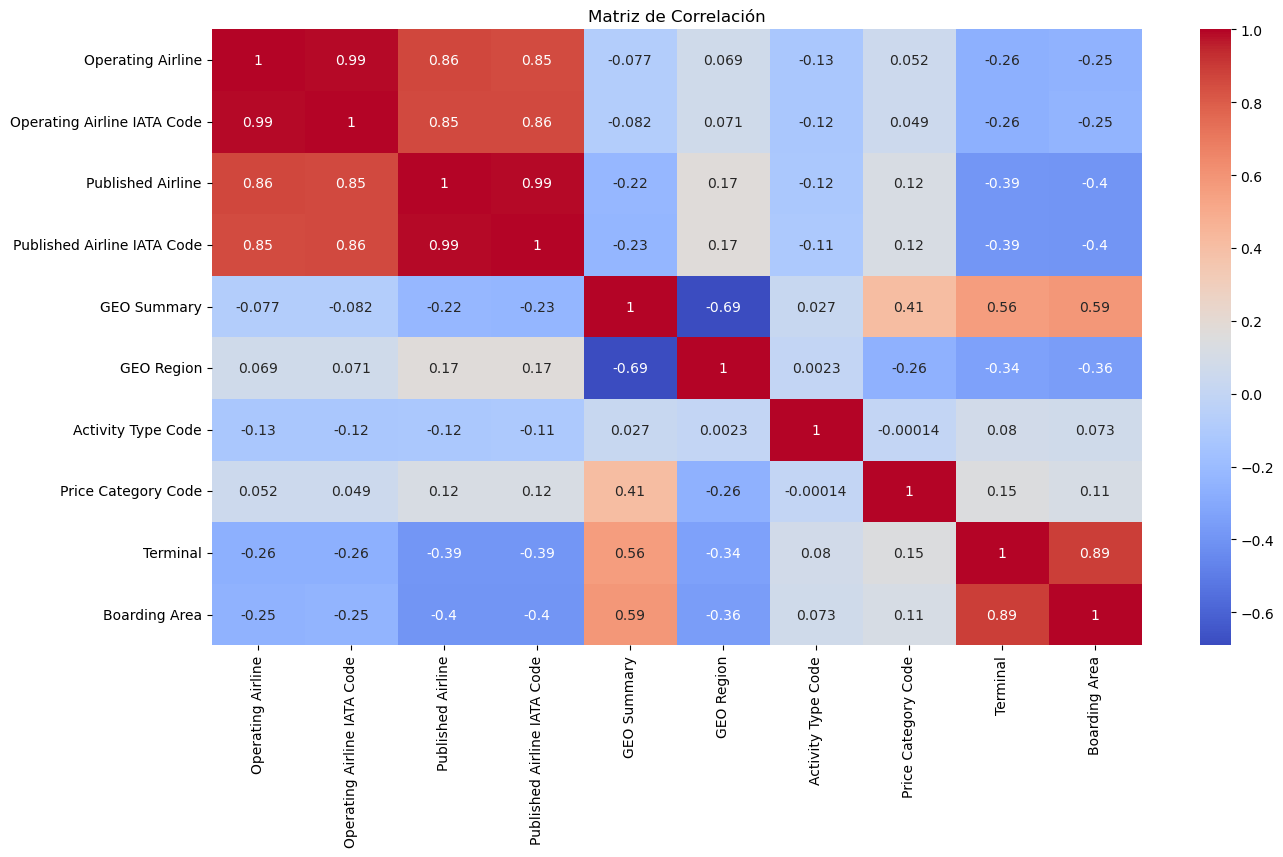

In [33]:
# Nombres de las columnas para las etiquetas del mapa de calor
column_labels = [col.replace("_index", "") for col in indexed_columns]

# Mapa de calor 
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_array, annot=True, cmap='coolwarm', xticklabels=column_labels, yticklabels=column_labels)
plt.title("Matriz de Correlación")
plt.show()

La matriz de correlación proporciona una visión detallada de las relaciones lineales entre las variables categóricas convertidas en índices numéricos. A continuación comentamos algunas observaciones clave derivadas de esta matriz:

1. **Correlación Positiva Fuerte entre Aerolíneas:**
   Las columnas relacionadas con aerolíneas, como `Operating Airline`, `Operating Airline IATA Code`, `Published Airline`, y `Published Airline IATA Code`, exhiben correlaciones positivas cercanas a 1. Esto indica una fuerte asociación entre estas variables, lo cual es razonable ya que representan información similar.
   Así mismo observamos una alta correlación entre La `Terminal` y `Boargind Area`, esta es una observación lógica ya que entendemos que el aeropuerto tiene asignado una áreas específicas de embarque a cada terminal.

2. **Correlaciones Negativas con 'GEO Summary':**
   La columna `GEO Summary` muestra correlaciones negativas con algunas de las variables relacionadas con aerolíneas. Este resultado sugiere que ciertas zonas geográficas pueden estar asociados inversamente con ciertos aspectos de la actividad de las aerolíneas. Es posible que algunas áreas geográficas tengan una mayor actividad de aerolíneas domesticas, mientras que otras estén más orientadas a vuelos internacionales. Esto también puede ser debido a los acuerdos políticos entre paises como restricciones de vuelo o acuerdos comerciales que puedan afectar a las operaciones de las aerolíneas con un perfil más internacional.

3. **Variables con Correlaciones Cercanas a Cero:**
   Algunas de las correlaciones entre variables son cercanas a cero, indicando una falta de relación lineal. Por ejemplo, la correlación entre `GEO Summary` y `Activity Type Code` es relativamente baja, sugiriendo que estas dos variables pueden ser independientes entre sí.

## 🧑‍💻4.2 Recta de Correlación Lineal

Realizo un análisis de correlación lineal considerando: Todas las aerolíneas; United Airlines y Air France.

Comparamos el volumen de pasajeros entre el primer y segundo periodo del año. El objetivo es examinar si, durante el primer periodo, caracterizado por una menor cantidad de festividades y periodos vacacionales, la cifra de pasajeros tiende a disminuir. En contraste, evaluamos si, en el segundo periodo del año, la correlación cambia y se observa un aumento en el número de pasajeros.

En caso de confirmarse esta correlación, se podrían optimizar los recursos o desarrollar estrategias comerciales más efectivas.

In [34]:
# Correlación Lineal para United Airline
data_united = data_cleaned.filter(col('Operating Airline') == 'United Airlines').orderBy('Activity Period')
data_united.show()
print("Número filas:",data_united.count())

# Transformo los datos en dataframe de pandas
pandas_data_united = data_united.toPandas()

# Usando Numpy extraigo la columna open y la conversitmos en un array unidemensional 
united_array = np.array(pandas_data_united['Adjusted Passenger Count'])
print("Longitud array: ", len(united_array))


+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+---------+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|    Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+---------+
|         200507|  United Airlines|                         UA|  United Airlines|                         UA|   Domestic|        US|          Deplaned|      

In [35]:
# Divido el array en 2 para comparar dos periodos
united_array_split = np.array_split(united_array, 2)

united_array_0 = united_array_split[0].astype(float)
united_array_1 = united_array_split[1].astype(float)

print("Longitud del Periodo Inicial:", len(united_array_0))
print("Longitud del Periodo Final:", len(united_array_1))

# Creación un DataFrame con los dos arrays
df = pd.DataFrame({'Periodo Inicial': united_array_0, 'Periodo Final': united_array_1})

# Calcular el coeficiente de correlación
correlation_coefficient = df['Periodo Inicial'].corr(df['Periodo Final'])

print("Coeficiente de correlación:", correlation_coefficient)

Longitud del Periodo Inicial: 446
Longitud del Periodo Final: 446
Coeficiente de correlación: 0.03844174477163181


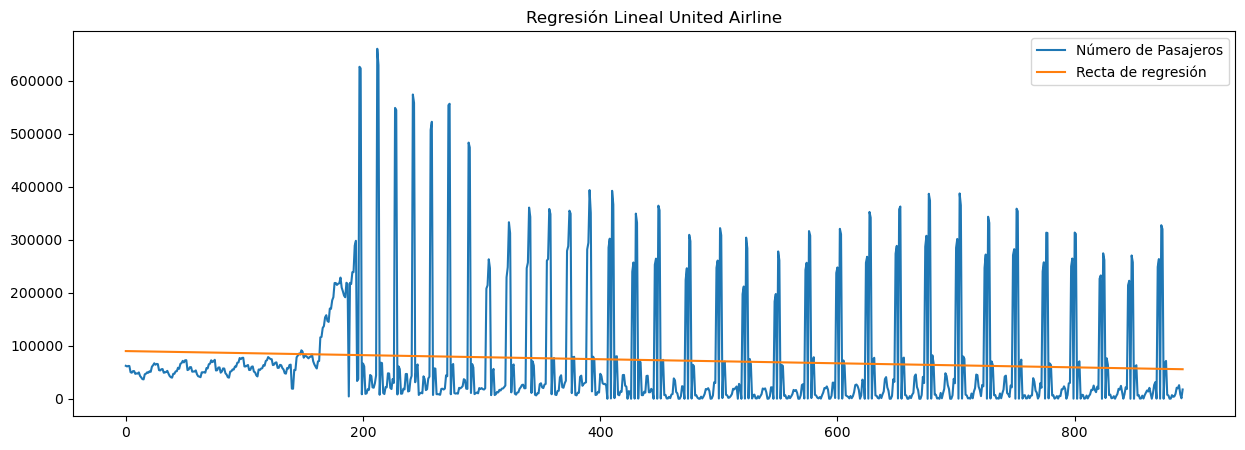

In [53]:
contador = []
for i in range(892):
    contador.append(i)

# Entrenar el modelo de regresión lineal
regr = linear_model.LinearRegression()
regr.fit(np.array(contador).reshape(-1, 1), united_array)

# Hacer predicciones con el modelo
prediction = regr.predict(np.array(contador).reshape(-1, 1))

# Mostrar en la gráfica los valores de HON y la recta de regresión
plt.figure(figsize=(15, 5))
plt.plot(united_array, label='Número de Pasajeros')
plt.plot(prediction, label='Recta de regresión')
plt.title('Regresión Lineal United Airline')
plt.legend()
plt.show()

In [57]:
data_france = data_cleaned.filter(col('Operating Airline') == 'Air France').orderBy('Activity Period')
data_france.show()
print("Número filas:",data_france.count())

# Transformo los datos en dataframe de pandas
pandas_data_france = data_france.toPandas()

# Usando Numpy extraigo la columna open y la conversitmos en un array unidemensional 
france_array = np.array(pandas_data_france['Adjusted Passenger Count'])
print("Longitud array: ", len(france_array))


+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+---------+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|    Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+---------+
|         200507|       Air France|                         AF|       Air France|                         AF|International|    Europe|        

In [38]:
# Divido el array en 2 para comparar dos periodos
france_array_split = np.array_split(france_array, 2)

france_array_0 = france_array_split[0].astype(float)
france_array_1 = france_array_split[1].astype(float)

print("Longitud del Periodo Inicial:", len(france_array_0))
print("Longitud del Periodo Final:", len(france_array_1))

# Creación un DataFrame con los dos arrays
df = pd.DataFrame({'Periodo Inicial': france_array_0, 'Periodo Final': france_array_1})

# Calcular el coeficiente de correlación
correlation_coefficient = df['Periodo Inicial'].corr(df['Periodo Final'])

print("Coeficiente de correlación:", correlation_coefficient)

Longitud del Periodo Inicial: 129
Longitud del Periodo Final: 129
Coeficiente de correlación: -0.5304669359093106


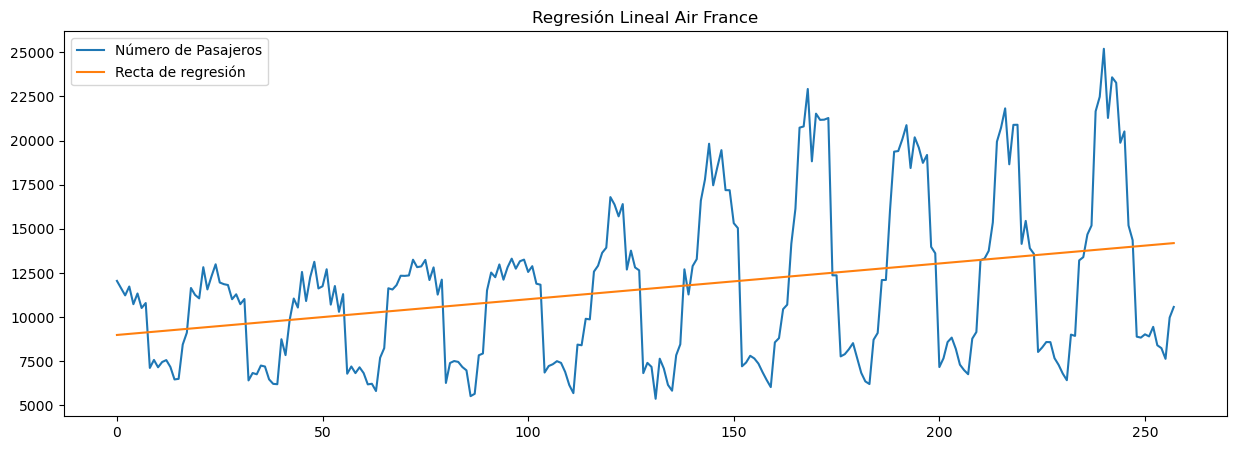

In [54]:
contador = []
for i in range(258):
    contador.append(i)

# Entrenar el modelo de regresión lineal
regr = linear_model.LinearRegression()
regr.fit(np.array(contador).reshape(-1, 1), france_array)

# Hacer predicciones con el modelo
prediction = regr.predict(np.array(contador).reshape(-1, 1))

# Mostrar en la gráfica los valores de HON y la recta de regresión
plt.figure(figsize=(15, 5))
plt.plot(france_array, label='Número de Pasajeros')
plt.plot(prediction, label='Recta de regresión')
plt.title('Regresión Lineal Air France')
plt.legend()
plt.show()

In [58]:
data_airline = data_cleaned.filter((col('Activity Period') >= 201301) & (col('Activity Period') <= 201312))

data_airline.show()
print("Número filas:",data_airline.count())

# Transformo los datos en dataframe de pandas
pandas_data_airline = data_airline.toPandas()

# Usando Numpy extraigo la columna open y la conversitmos en un array unidemensional 
airline_array = np.array(pandas_data_airline['Adjusted Passenger Count'])
print("Longitud array: ", len(airline_array))

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-------+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|  Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-------+
|         201306|     Horizon Air |                         QX|  Alaska Airlines|                         AS|     Domesti

In [41]:
# Divido el array en 2 para comparar dos periodos
airline_array_split = np.array_split(airline_array, 2)

airline_array_0 = airline_array_split[0].astype(float)
airline_array_1 = airline_array_split[1].astype(float)

print("Longitud del Periodo Inicial:", len(airline_array_0))
print("Longitud del Periodo Final:", len(airline_array_1))

# Creación un DataFrame con los dos arrays
df = pd.DataFrame({'Periodo Inicial': airline_array_0, 'Periodo Final': airline_array_1})

# Calcular el coeficiente de correlación
correlation_coefficient = df['Periodo Inicial'].corr(df['Periodo Final'])

print("Coeficiente de correlación:", correlation_coefficient)

Longitud del Periodo Inicial: 673
Longitud del Periodo Final: 673
Coeficiente de correlación: 0.1441096140903516


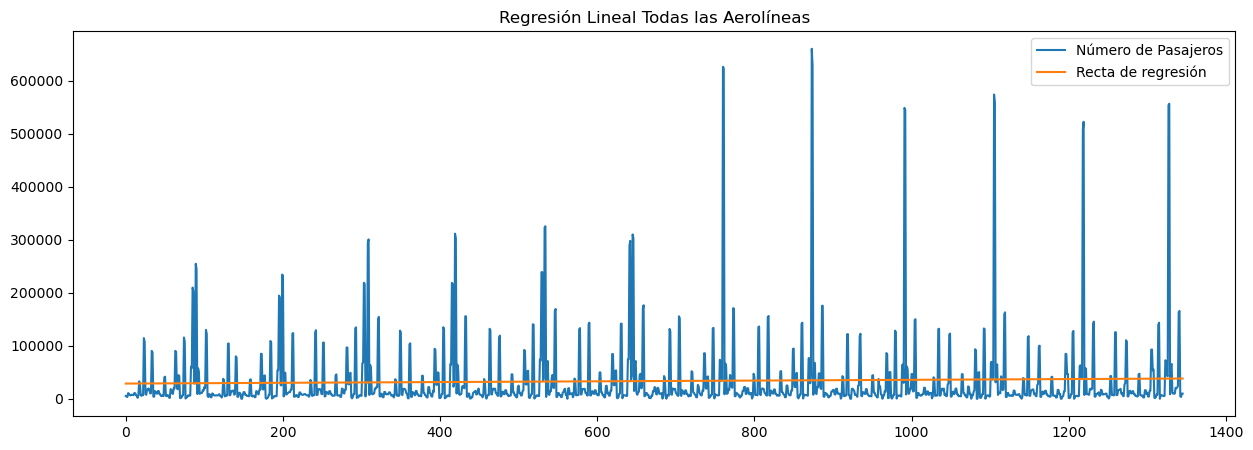

In [56]:
contador = []
for i in range(len(airline_array)):
    contador.append(i)

# Entrenar el modelo de regresión lineal
regr = linear_model.LinearRegression()
regr.fit(np.array(contador).reshape(-1, 1), airline_array)

# Hacer predicciones con el modelo
prediction = regr.predict(np.array(contador).reshape(-1, 1))

# Mostrar en la gráfica los valores de HON y la recta de regresión
plt.figure(figsize=(15, 5))
plt.plot(airline_array, label='Número de Pasajeros')
plt.plot(prediction, label='Recta de regresión')
plt.title('Regresión Lineal Todas las Aerolíneas')
plt.legend()
plt.show()

## 🔮 5.1 Algoritmo de Regresión Lineal

### 🔮 5.2 Regresión Líneal Pasajeros

In [49]:
# Selecciono las columnas relevantes para el modelo
selected_columns = ['Adjusted Passenger Count', 'Year', 'Month']

# Convierto 'Month' a formato numérico ya que inicialmente esta tipado como texto
selected_data = data_cleaned.select(selected_columns)
selected_data = selected_data.withColumn('Month',
                                         when(col('Month') == 'January', 1)
                                         .when(col('Month') == 'February', 2)
                                         .when(col('Month') == 'March', 3)
                                         .when(col('Month') == 'April', 4)
                                         .when(col('Month') == 'May', 5)
                                         .when(col('Month') == 'June', 6)
                                         .when(col('Month') == 'July', 7)
                                         .when(col('Month') == 'August', 8)
                                         .when(col('Month') == 'September', 9)
                                         .when(col('Month') == 'October', 10)
                                         .when(col('Month') == 'November', 11)
                                         .when(col('Month') == 'December', 12)
                                         .otherwise(0))

# Cambio el tipo de datos de 'Month' a InterType
selected_data = selected_data.withColumn('Month', selected_data['Month'].cast (IntegerType()))

# Creo un VectorAssembler para combinar las variables en un solo vector
assembler = VectorAssembler(inputCols=('Month', 'Year'), outputCol = 'features')

# enero el modelo de regresión lineal
lr = LinearRegression(featuresCol='features', labelCol='Adjusted Passenger Count')
pipeline = Pipeline(stages=[assembler, lr])

# Divido el conjunto de datos para obtener un data set de entrenamiento (80%) y otro de prueba (20%)
(train_data, test_data) = selected_data.randomSplit([0.8, 0.2], seed=1234)

# Entreno eal modelo con los datos train_data
model = pipeline.fit(train_data)

# Realizo las predicciones en el conjunto test_data
predictions = model.transform(test_data)
predictions = predictions.withColumn('prediction', round('prediction', 2))
predictions.select('prediction', 'Adjusted Passenger Count')
predictions.show()

+------------------------+----+-----+-------------+----------+
|Adjusted Passenger Count|Year|Month|     features|prediction|
+------------------------+----+-----+-------------+----------+
|                       1|2006|   11|[11.0,2006.0]|  25924.41|
|                       2|2006|   11|[11.0,2006.0]|  25924.41|
|                       4|2015|    3| [3.0,2015.0]|  34396.29|
|                       5|2006|    6| [6.0,2006.0]|  24794.27|
|                       5|2007|    2| [2.0,2007.0]|   25032.4|
|                       5|2007|    5| [5.0,2007.0]|  25710.48|
|                       6|2008|    8| [8.0,2008.0]|  27530.79|
|                       8|2008|    4| [4.0,2008.0]|  26626.69|
|                      12|2015|    6| [6.0,2015.0]|  35074.37|
|                      14|2008|    1| [1.0,2008.0]|  25948.61|
|                      14|2015|   11|[11.0,2015.0]|  36204.51|
|                      20|2005|    7| [7.0,2005.0]|  23878.07|
|                      20|2005|    9| [9.0,2005.0]|  24

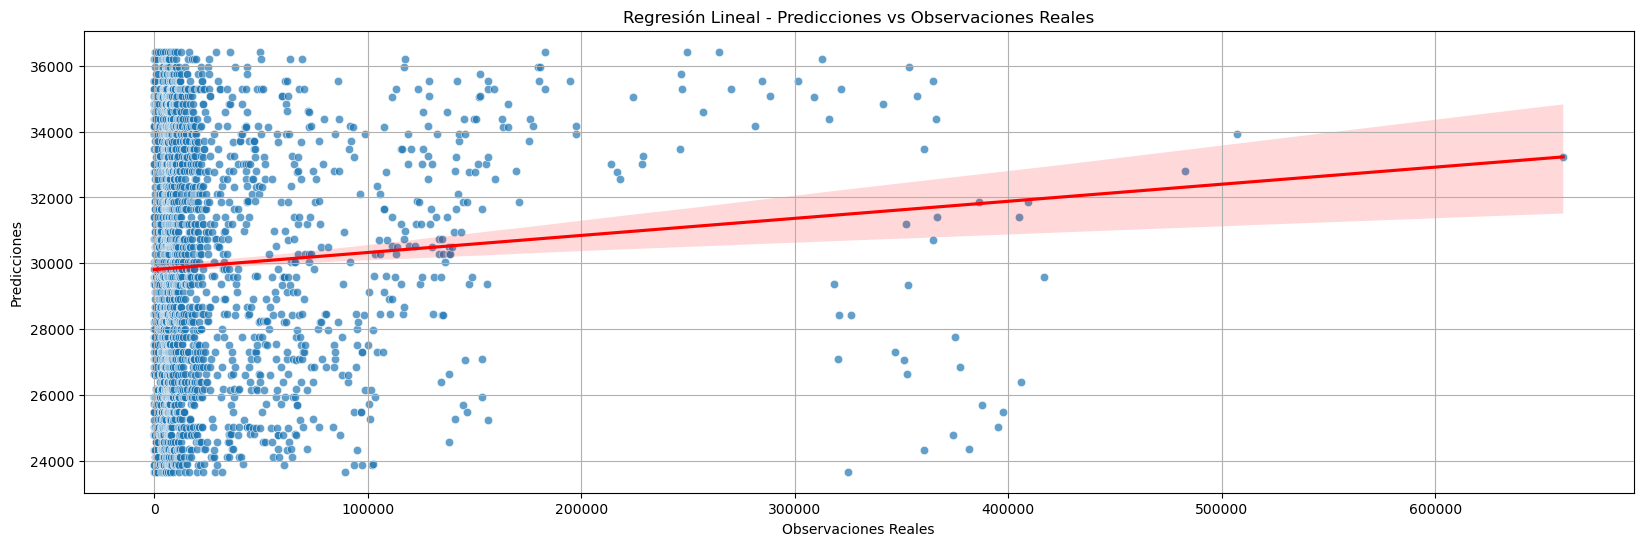

In [51]:
# Transformo los datos del modelo a Pandas para generar un gráfico
predictions_pd = predictions.select('Adjusted Passenger Count', 'prediction').toPandas()

# Genero un gráfico de dispersión con las predicciones y las observaciones
plt.figure(figsize=(20,6))
sns.scatterplot(x='Adjusted Passenger Count', y='prediction', data=predictions_pd, alpha=0.7)
sns.regplot(x='Adjusted Passenger Count', y='prediction', data=predictions_pd, scatter=False, color='red')

plt.title('Regresión Lineal - Predicciones vs Observaciones Reales')
plt.xlabel('Observaciones Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

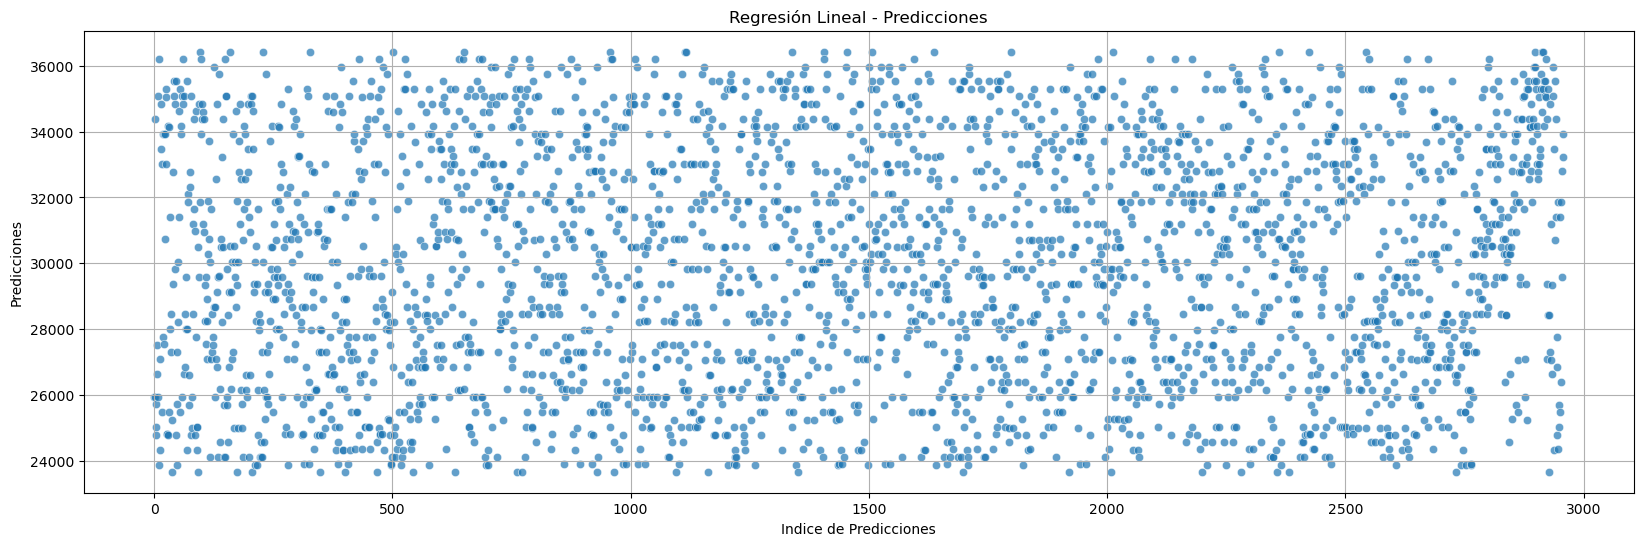

In [52]:
predictions_pd = predictions.select('prediction').toPandas()

# Genero un gráfico de dipersiñon solo con las predicciones
plt.figure(figsize=(20,6))
sns.scatterplot(x=predictions_pd.index, y='prediction', data=predictions_pd, alpha=0.7)

plt.title('Regresión Lineal - Predicciones')
plt.xlabel('Indice de Predicciones')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

### 🔮 5.3 Regresión Lineal entre Aerolineas

In [65]:
selected_columns = ['Adjusted Passenger Count', 'Year', 'Month', 'Operating Airline', 'GEO Region']

# Seleccionar y transformar 'Month' a formato numérico
selected_data = data_cleaned.select(selected_columns)
selected_data = selected_data.withColumn('Month',
                                         when(col('Month') == 'January', 1)
                                         .when(col('Month') == 'February', 2)
                                         .when(col('Month') == 'March', 3)
                                         .when(col('Month') == 'April', 4)
                                         .when(col('Month') == 'May', 5)
                                         .when(col('Month') == 'June', 6)
                                         .when(col('Month') == 'July', 7)
                                         .when(col('Month') == 'August', 8)
                                         .when(col('Month') == 'September', 9)
                                         .when(col('Month') == 'October', 10)
                                         .when(col('Month') == 'November', 11)
                                         .when(col('Month') == 'December', 12)
                                         .otherwise(0))

# Cambiar el tipo de datos de 'Month' a IntegerType
selected_data = selected_data.withColumn('Month', selected_data['Month'].cast(IntegerType()))

# Crear un StringIndexer para convertir las variables categóricas a numéricas
indexer_airline = StringIndexer(inputCol='Operating Airline', outputCol='AirlineIndex')
indexer_geo = StringIndexer(inputCol='GEO Region', outputCol='GeoIndex')

# Crear un OneHotEncoder para las variables indexadas
encoder = OneHotEncoder(inputCols=['AirlineIndex', 'GeoIndex'], outputCols=['AirlineVec', 'GeoVec'])

# Crear un VectorAssembler para combinar todas las variables en un solo vector
assembler = VectorAssembler(inputCols=['Month', 'Year', 'AirlineVec', 'GeoVec'], outputCol='features')

# Crear el modelo de regresión lineal
lr = LinearRegression(featuresCol='features', labelCol='Adjusted Passenger Count')

# Crear el pipeline con todas las etapas
pipeline = Pipeline(stages=[indexer_airline, indexer_geo, encoder, assembler, lr])

# Dividir el conjunto de datos para obtener un conjunto de entrenamiento (80%) y otro de prueba (20%)
(train_data, test_data) = selected_data.randomSplit([0.8, 0.2], seed=1234)

# Entrenar el modelo con los datos de entrenamiento
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Redondear las predicciones
predictions = predictions.withColumn('prediction', round('prediction', 2))

# Seleccionar las columnas relevantes en las predicciones
predictions.select('prediction', 'Adjusted Passenger Count', 'Operating Airline', 'GEO Region').show()

+----------+------------------------+--------------------+----------+
|prediction|Adjusted Passenger Count|   Operating Airline|GEO Region|
+----------+------------------------+--------------------+----------+
|    431.08|                       1|         Ameriflight|        US|
|      2.02|                       2|Evergreen Interna...|      Asia|
|  31578.31|                       4|     United Airlines|    Mexico|
|  -1138.46|                       5|         Ameriflight|        US|
|  -1369.46|                       5|         Ameriflight|        US|
|   -427.74|                       5|         Ameriflight|        US|
|   1538.61|                       6|         Ameriflight|        US|
|  79112.03|                       8|  Southwest Airlines|        US|
|  32520.03|                      12|     United Airlines|    Mexico|
|  78170.31|                      14|  Southwest Airlines|        US|
|   88481.8|                      14|  Southwest Airlines|        US|
|  19798.52|        

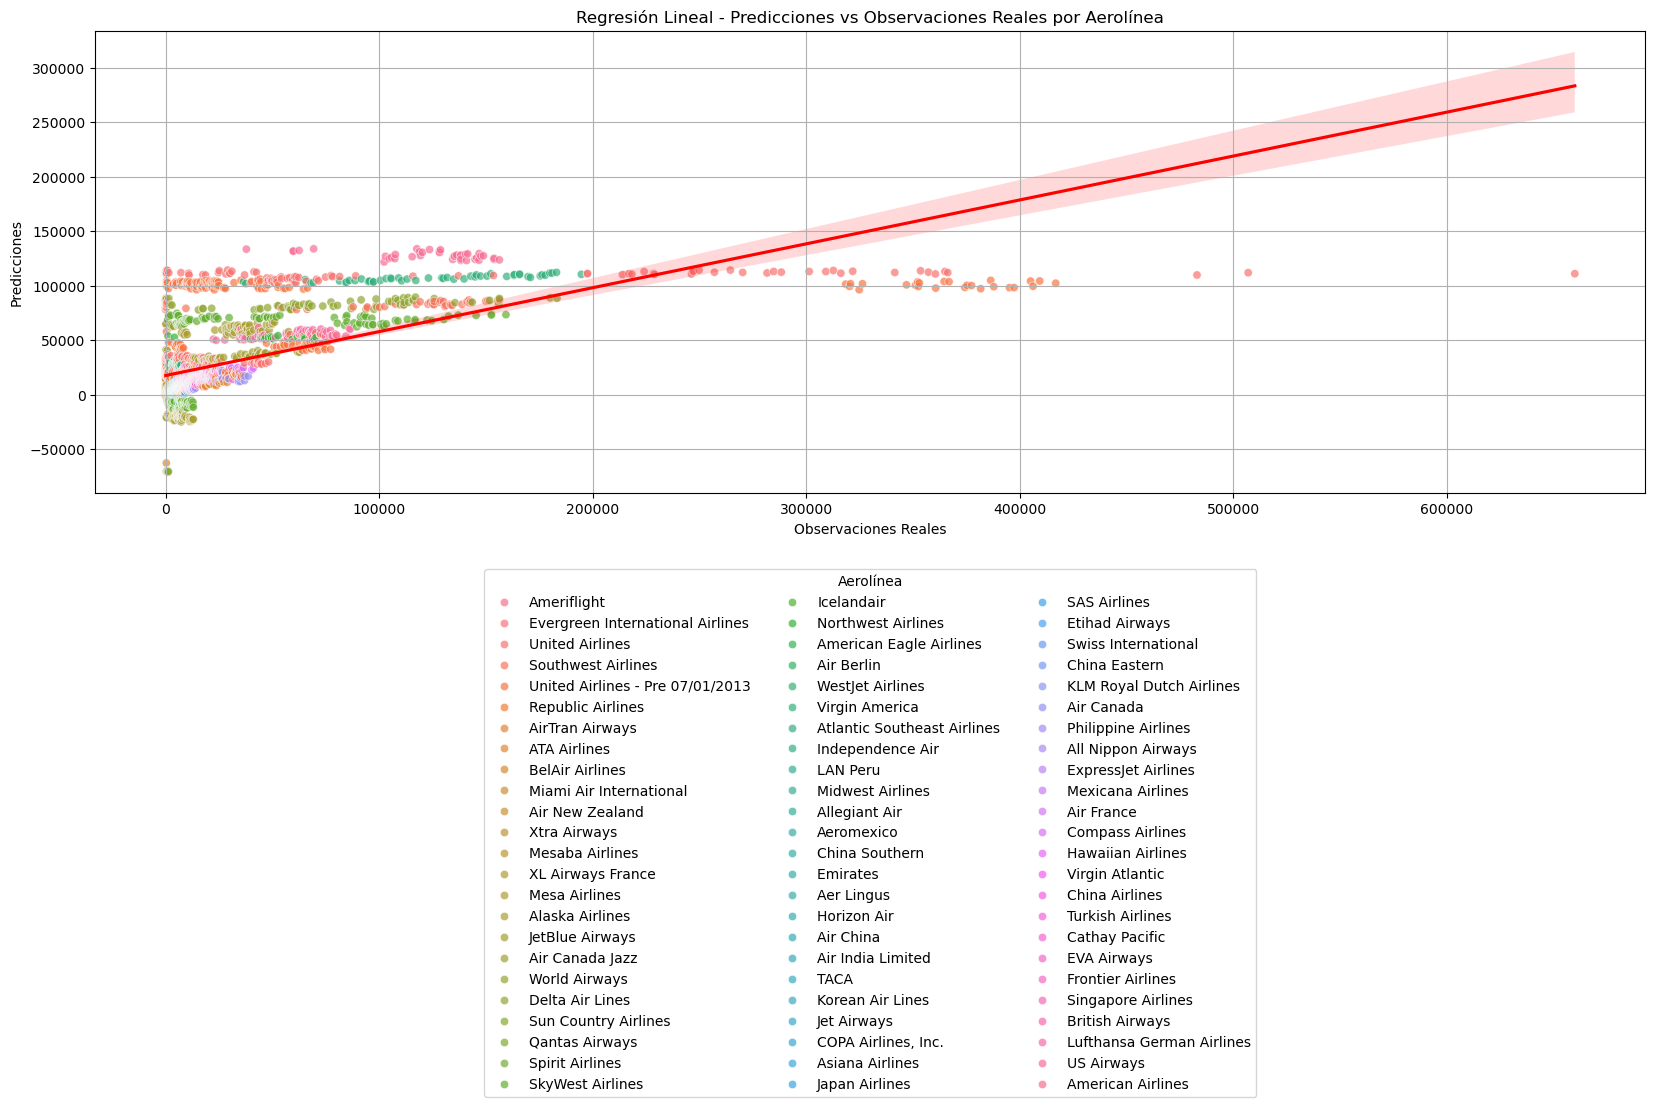

In [70]:
# Transformar los datos del modelo a Pandas para generar el gráfico
predictions_pd = predictions.select('Adjusted Passenger Count', 'prediction', 'Operating Airline', 'GEO Region').toPandas()

# Generar un gráfico de dispersión con las predicciones y las observaciones
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Adjusted Passenger Count', y='prediction', hue='Operating Airline', data=predictions_pd, alpha=0.7)

# Añadir una línea de regresión
sns.regplot(x='Adjusted Passenger Count', y='prediction', data=predictions_pd, scatter=False, color='red')

plt.title('Regresión Lineal - Predicciones vs Observaciones Reales por Aerolínea')
plt.xlabel('Observaciones Reales')
plt.ylabel('Predicciones')
plt.legend(title='Aerolínea', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)  # Ajustar la ubicación de la leyenda
plt.grid(True)
plt.show()

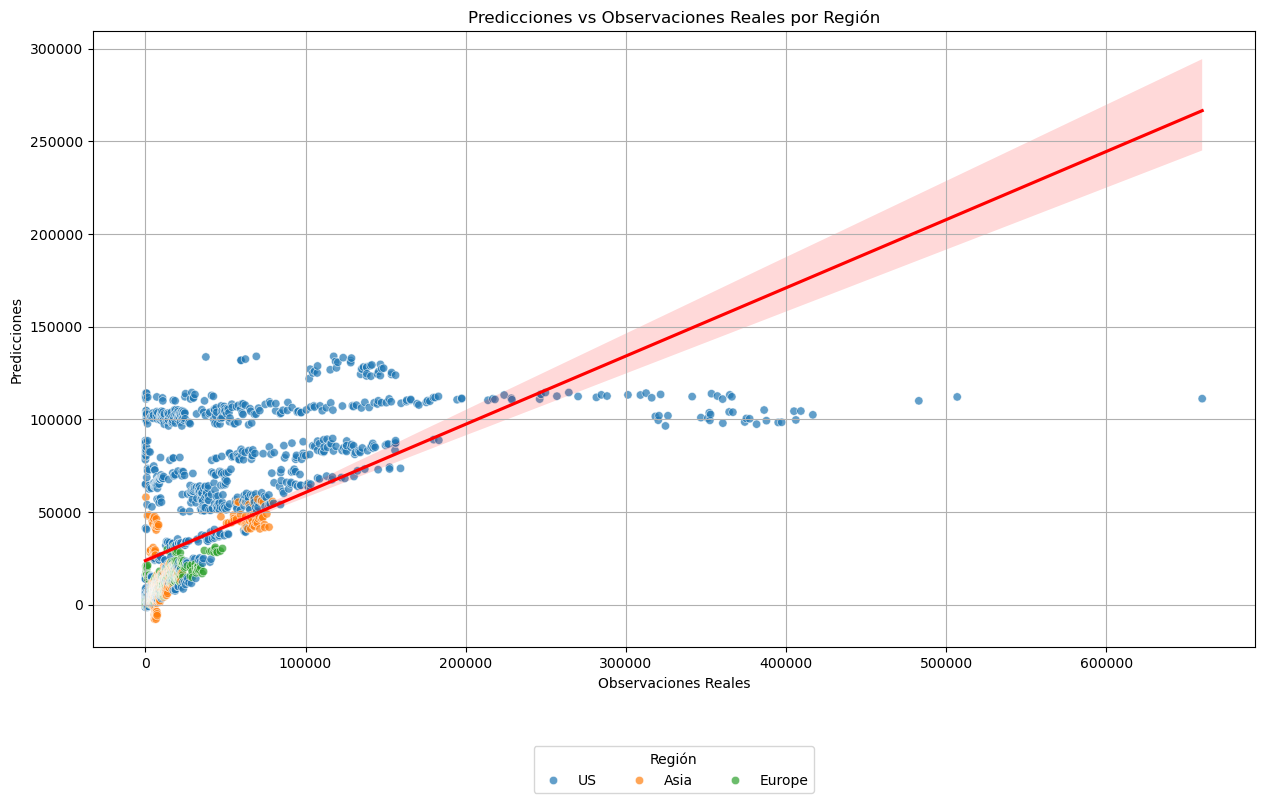

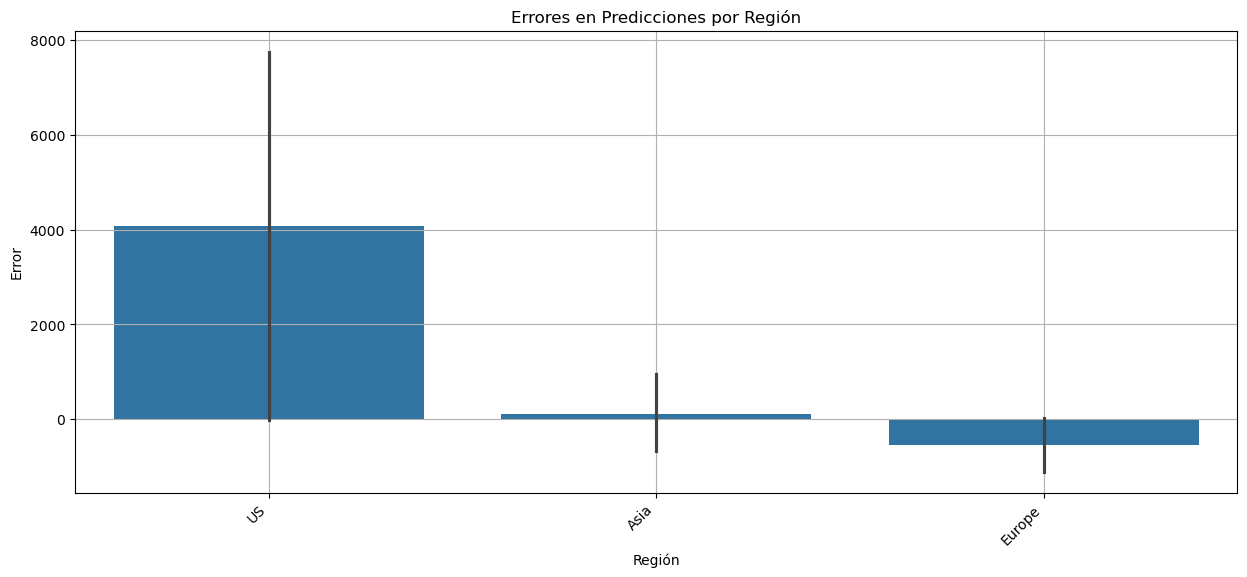

In [76]:
selected_columns = ['prediction', 'Adjusted Passenger Count', 'GEO Region']

# Filtro los datos para incluir las regiones populares
regiones_deseadas = ['US', 'Europe', 'Asia'] 
popular_routes_data = predictions.select(selected_columns).filter(predictions['GEO Region'].isin(regiones_deseadas))

# Transformo los datos a Pandas para facilitar el análisis
popular_routes_pd = popular_routes_data.toPandas()

# 1. Visualización de Predicciones vs. Valores Reales por Región
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Adjusted Passenger Count', y='prediction', hue='GEO Region', data=popular_routes_pd, alpha=0.7)
sns.regplot(x='Adjusted Passenger Count', y='prediction', data=popular_routes_pd, scatter=False, color='red')

plt.title('Predicciones vs Observaciones Reales por Región')
plt.xlabel('Observaciones Reales')
plt.ylabel('Predicciones')
plt.legend(title='Región', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True)
plt.show()

# 2. Análisis de Errores por Región
popular_routes_pd['Error'] = popular_routes_pd['prediction'] - popular_routes_pd['Adjusted Passenger Count']

# Visualización de Errores por Región
plt.figure(figsize=(15, 6))
sns.barplot(x='GEO Region', y='Error', data=popular_routes_pd)
plt.title('Errores en Predicciones por Región')
plt.xlabel('Región')
plt.ylabel('Error')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()